In [59]:
#1. Importing necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

#Regression algorythms
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
#2. Loading and splitting the data.
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)

In [3]:
#3. Data standardization.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
#4. List of algorithms.
models = [
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('SVR', SVR()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('k-NN', KNeighborsRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Neural Network', MLPRegressor(max_iter=10000)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror')),
    ('CatBoost', CatBoostRegressor(verbose=0))
]

In [5]:
#5. Cross-validation parameters.
cv = KFold(n_splits=5, shuffle=True, random_state=345)

In [6]:
#6. Functions to generate model metrics.
def evaluate_model(name, model, X_train, y_train, cv):
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    nmae_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    ev_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='explained_variance')

    return {
        'Model': name,
        'MSE': -nmse_scores.mean(),  # Convert NMSE to MSE; first metric sould be the same as scoring in hyperparameter tuning
        'MAE': -nmae_scores.mean(),  # Convert NMAE to MAE
        'R2': r2_scores.mean(),
        'Explained Variance': ev_scores.mean()
    }

def evaluate_models(models, X_train, y_train, cv):
    return [evaluate_model(name, model, X_train, y_train, cv) for name, model in models]


In [7]:
#7. Generating metrics for default hyperparameters.
default_results = evaluate_models(models, X_train, y_train, cv)
df_default = pd.DataFrame(default_results)

In [8]:
#8. Defining hyperparameter grids for each algorythm.

param_grids = {
    'Ridge Regression': {
        'alpha': [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    },
    'Lasso Regression': {
        'alpha': [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    },
    'SVR': {
        'C': [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],
        'gamma': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
        'kernel': ['rbf', 'linear']
    },
    'Decision Tree': {
        'max_depth': [None, 2, 5, 10, 20, 30, 40, 50, 100],
        'min_samples_split': [2, 4, 5, 6, 8, 10, 12, 15],
        'min_samples_leaf': [1, 2, 4, 5, 8, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 25, 40, 50, 80, 100],
        'max_depth': [None, 5, 10, 20, 25, 30, 40],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 4, 5, 8, 10, 15]
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'Gradient Boosting': {
        'n_estimators': [10, 20, 25, 30, 40, 50, 80, 100, 150, 200],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
        'max_depth': [3, 5, 7, 9, 11]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 9]
    },
    'CatBoost': {
        'iterations': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'depth': [3, 5, 7, 9]
    }

}

In [9]:
#9. Generating best hyperparameter sets based on specified metric using grid search.

best_models = []
hp_scoring = 'neg_mean_squared_error'


for name, model in models:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv, scoring=hp_scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models.append((name, grid_search.best_estimator_, grid_search.best_params_))
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Tuning Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 5.0}
Tuning Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 1.0}
Tuning SVR...
Best parameters for SVR: {'C': 50.0, 'gamma': 0.01, 'kernel': 'rbf'}
Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 8, 'n_estimators': 25}
Tuning k-NN...
Best parameters for k-NN: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Tuning Neural Network...


c:\Users\cezar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Tuning CatBoost...
Best parameters for CatBoost: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}


In [10]:
#10. Generating additional metrics using the best hyperparameter sets.
tuned_results = evaluate_models([(name, model) for name, model, params in best_models], X_train, y_train, cv)
df_tuned = pd.DataFrame(tuned_results)

In [14]:
#11. Formatting tables.
def styled_df(df):
    styled_df = df.style.background_gradient(subset=['R2', 'Explained Variance'], cmap='RdYlGn')
    styled_df = styled_df.background_gradient(subset=['MSE', 'MAE'], cmap='RdYlGn_r') #reverse color map for minimized metrics
    if 'Hyperparameters' in df.columns:
        styled_df = styled_df.set_properties(subset=['Hyperparameters'], **{'text-align': 'left'})
        styled_df = styled_df.set_table_styles({
            'Hyperparameters': [{'selector': 'th', 'props': [('text-align', 'left')]}]
        })
    return styled_df

In [15]:
#12.1. Displaying the generated table for default hyperparameters.
styled_df(df_default)

,Model,MSE,MAE,R2,Explained Variance
0,Ridge Regression,3017.384479,44.988392,0.455947,0.470067
1,Lasso Regression,3002.962386,44.841481,0.460822,0.473699
2,SVR,5048.658620,60.023966,0.118126,0.144811
3,Decision Tree,6391.249336,63.439356,-0.126364,-0.132791
4,Random Forest,3534.138756,49.091017,0.375423,0.386579
5,k-NN,3685.557257,48.579219,0.340087,0.349525
6,Gradient Boosting,3468.241212,47.628026,0.368310,0.378953
7,Neural Network,3478.896497,46.402332,0.308590,0.363968
8,XGBoost,4167.346671,52.814794,0.244190,0.263011
9,CatBoost,3452.565694,48.454933,0.376479,0.384748


In [16]:
#12.2. Displaying the generated table for tuned hyperparameters.
params_dict = {model[0]: model[2] for model in best_models}
df_tuned['Hyperparameters'] = df_tuned['Model'].map(params_dict).apply(lambda x: str(x))
styled_df(df_tuned)

,Model,MSE,MAE,R2,Explained Variance,Hyperparameters
0,Ridge Regression,3015.265061,44.888230,0.457149,0.470543,{'alpha': 5.0}
1,Lasso Regression,3002.962386,44.841481,0.460822,0.473699,{'alpha': 1.0}
2,SVR,2998.148894,44.802185,0.462328,0.477003,"{'C': 50.0, 'gamma': 0.01, 'kernel': 'rbf'}"
3,Decision Tree,3889.810261,49.963001,0.304464,0.323282,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}"
4,Random Forest,3347.032588,47.849025,0.387132,0.417767,"{'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 8, 'n_estimators': 25}"
5,k-NN,3445.401476,47.025107,0.385431,0.395019,"{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}"
6,Gradient Boosting,3355.786821,47.564618,0.396019,0.406713,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}"
7,Neural Network,3260.624743,47.340965,0.384237,0.389642,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}"
8,XGBoost,3461.701999,48.454532,0.376167,0.389286,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}"
9,CatBoost,3114.725718,45.809044,0.437775,0.448923,"{'depth': 3, 'iterations': 100, 'learning_rate': 0.1}"


In [58]:
#13. Displaying best result
best_model = df_tuned.iloc[df_tuned.iloc[:, 1].idxmin(), 0] #change .idxmin to .idxmax if higher value of hp_scoring = better 
for nazwa, model, hp in best_models:
    if nazwa == best_model:
        best_hp = hp

print(f"""The best result during hyperparameter tuning in terms of {hp_scoring} 
was achieved by {best_model} 
with hyperparameters: {best_hp}""")

The best result during hyperparameter tuning in terms of neg_mean_squared_error 
was achieved by SVR 
with hyperparameters: {'C': 50.0, 'gamma': 0.01, 'kernel': 'rbf'}


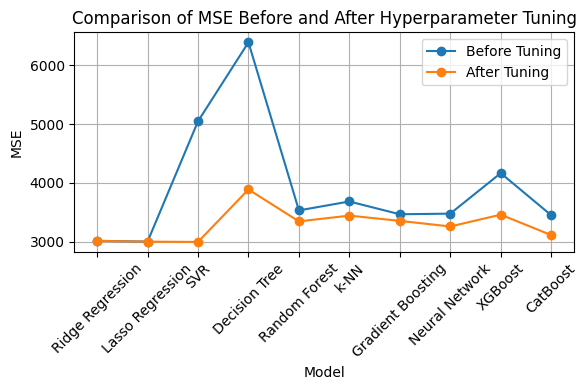

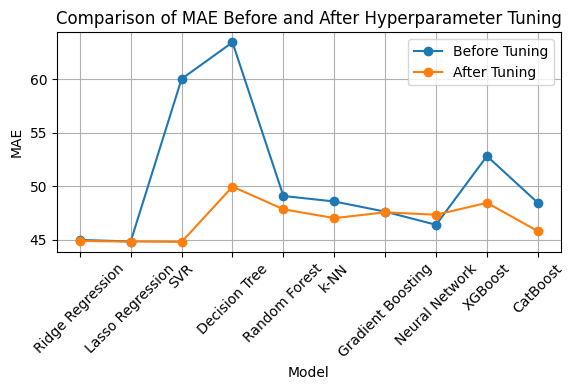

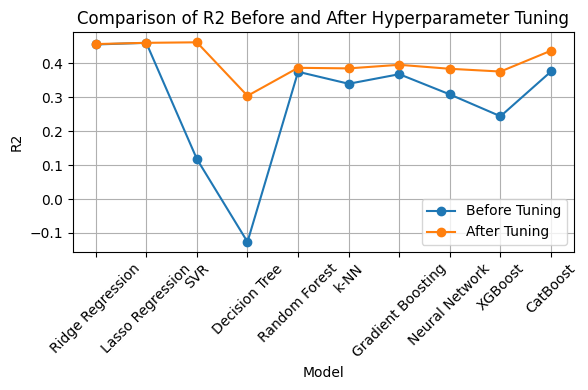

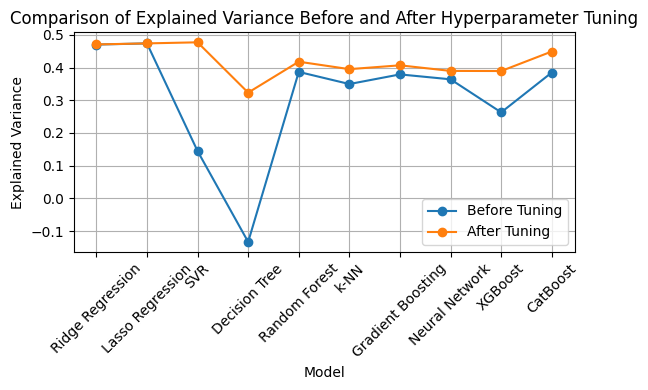

In [65]:
#14. Charts before and after
metrics = ['MSE', 'MAE', 'R2', 'Explained Variance']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.plot(df_default['Model'], df_default[metric], marker='o', label='Before Tuning')
    plt.plot(df_tuned['Model'], df_tuned[metric], marker='o', label='After Tuning')
    plt.title(f'Comparison of {metric} Before and After Hyperparameter Tuning')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()